In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
import sys

### Reading data

In [3]:
DATA_FOLDER = './data/'

In [4]:
openfood_file = "en.openfoodfacts.org.products.csv"
openfood = pd.read_csv(DATA_FOLDER + openfood_file, sep = '\t')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,3,5,24,25,26,28,36,41,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Remembering Research question

2. Is there a trend over time to consume more local products?

    - Are new products mostly using primary resources from Switzerland? Or from other countries inside Europe?
    - Are new products mostly manufactured in Switzerland? Or from other countries inside Europe?
    - Is there a trend over time to local products to promote their origin?

The first decision is to narrow down the search, just for Switzerland products

In [5]:
foodSwitzerland = openfood[openfood['countries_tags']=="en:switzerland"]

In [6]:
nbProdSwit = len(foodSwitzerland)
print("Number of products: ", nbProdSwit)
foodSwitzerland.head()

Number of products:  13454


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
285,0000003301098,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1527593074,2018-05-29T11:24:34Z,1527593109,2018-05-29T11:25:09Z,Mini cuchaule au beurre,NaN,100 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356,0000013000004,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1484431999,2017-01-14T22:13:19Z,1484432028,2017-01-14T22:13:48Z,Kochspeck,NaN,686 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1040,00025393,http://world-en.openfoodfacts.org/product/0002...,openfoodfacts-contributors,1530019114,2018-06-26T13:18:34Z,1530019311,2018-06-26T13:21:51Z,Salade de lentilles,NaN,200 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1329,0007200000021,http://world-en.openfoodfacts.org/product/0007...,date-limite-app,1418991821,2014-12-19T12:23:41Z,1442754589,2015-09-20T13:09:49Z,Sauce bolognaise,NaN,420 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2171,0010000002218,http://world-en.openfoodfacts.org/product/0010...,date-limite-app,1442659864,2015-09-19T10:51:04Z,1461430836,2016-04-23T17:00:36Z,Ikea Lachs,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. A first perspective: Compare old vs new products inside the dataset

A product in the dataset is considered "old" if its description was uploaded to the dataset before February 2017. By the contrary, it is considered as "new" if its description was uploaded after that date.

_As that definition is a little rigid, in order to get closer to the real situation, the following assumption is made: From the total products uploaded to the dataset after February 2017, 20% are old products._  

A first perspective to tackle the research question, is to compare how in this more than 6 years of existance of the dataset, the characteristics of the products have changed. Specifically, we would like to know if there have been some changes in the origin of the primary resources, or in the origin of the manufacture or in the labels of the products.

The study of the evolution in time of each one of those features, will include an __exploratory data analysis__, and will calculate the __correlation__ between each feature and the time.
Finally, a study including the three features will be done, aiming to find an aggregated differentiated behavior in time, reflected in different clusters of periods of time. For that the __K-modes algorithm__ will be used.

In [7]:
print("Date of first upload: ", min(foodSwitzerland['created_datetime']))
print("Date of last upload retrieved: ", max(foodSwitzerland['created_datetime']))

Date of first upload:  2012-05-16T18:33:35Z
Date of last upload retrieved:  2018-11-23T08:40:49Z


In [8]:
foodSwitzerland['created_datetime'] = pd.to_datetime(foodSwitzerland['created_datetime'])
foodSwitzerland = foodSwitzerland.sort_values(by='created_datetime')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


The uploads of products sold in Switzerland, behaves differently in time. Taking into account the histogram presented below, two periods of time are defined:
- Period 1: Created for studying the behaviour from "old" products. Products uploaded before Feb 2017.
- Period 2: Created for studying the behaviour from "new" products. Products uploaded after Feb 2017.

Old products:  11826.8
New products:  1627.2


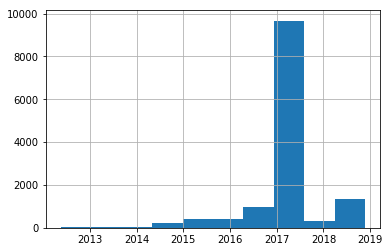

In [9]:
rateOldInNew = 0.2
old_products = len(foodSwitzerland[foodSwitzerland['created_datetime']<"2017-03-01 00:00:00"])
print("Old products: ", old_products + (len(foodSwitzerland)-old_products)*(rateOldInNew))
print("New products: ", (len(foodSwitzerland)-old_products)*(1-rateOldInNew))
foodSwitzerland['created_datetime'].hist()

Before making subdivision of data:

In [10]:
filter_ch = '[Ss]witzerland|[Ss]uisse|[Ss]chweiz|[Ss]vizerra'
filter_local = '[Ss]witzerland|[Ss]uisse|[Ss]chweiz|[Ss]vizerra|[Ll]ocal'

place = pd.Series(['Other country','Switzerland', 'No information'], index=[0,1,2])
refLabel = pd.Series(['Other Label','Related with Switzerland', 'No information'], index=[0,1,2]) 

foodSwitzerland["originsCat"] = foodSwitzerland["origins"].str.contains(filter_ch,regex=True).map(place,na_action='ignore')
foodSwitzerland["manuCat"] = foodSwitzerland["manufacturing_places"].str.contains(filter_ch,regex=True).map(place,na_action='ignore')
foodSwitzerland["labCat"] = foodSwitzerland["labels_tags"].str.contains(filter_local,regex=True).map(refLabel,na_action='ignore')

Now, let's do the subdivision in the two periods, taking care of our assumption of 20%:

In [11]:
foodSwitzerlandBef = foodSwitzerland[foodSwitzerland['created_datetime']<"2017-03-01 00:00:00"]
foodSwitzerlandAft = foodSwitzerland[foodSwitzerland['created_datetime']>="2017-03-01 00:00:00"]

befInAft = foodSwitzerlandAft.sample(n=int(rateOldInNew*len(foodSwitzerlandAft)), replace=False)
foodSwitzerlandBef = pd.concat([foodSwitzerlandBef,befInAft],axis=0)

for i in range (0,len(befInAft)):
    foodSwitzerlandAft = foodSwitzerlandAft[foodSwitzerlandAft['code']!=befInAft['code'].iloc[i]]
print("Number of Old products: ", np.shape(foodSwitzerlandBef))
print("Number of New products: ", np.shape(foodSwitzerlandAft))

Number of Old products:  (11826, 176)
Number of New products:  (1627, 176)


### 2.1. Study of the evolution in time of each one of the interest features

### 2.1.1 With respect to: Origin of the primary resources

First, bootstrapping for include confidence intervals to results

In [20]:
#before
propSB_100ite = np.zeros (100)
propOCB_100ite = np.zeros (100)
#after
propSA_100ite = np.zeros (100)
propOCA_100ite = np.zeros (100)

for iteration in range(0,100):
    #before
    temp_bef = foodSwitzerlandBef["originsCat"].sample(n=len(foodSwitzerlandBef), replace=True)
    propSB_100ite[iteration] = (sum(temp_bef=="Switzerland")/len(foodSwitzerlandBef))
    propOCB_100ite[iteration] = sum(temp_bef=="Other country")/len(foodSwitzerlandBef)
    #after
    temp_aft = foodSwitzerlandAft["originsCat"].sample(n=len(foodSwitzerlandAft), replace=True)
    propSA_100ite[iteration] = sum(temp_aft=="Switzerland")/len(foodSwitzerlandAft)
    propOCA_100ite[iteration] = sum(temp_aft=="Other country")/len(foodSwitzerlandAft)
    
    #Relation of time evolution and difference of products in each categories
    difpropB = propSB_100ite[iteration]-propOCB_100ite[iteration]
    difpropA = propSB_100ite[iteration]-propOCA_100ite[iteration]

#Calculating standard deviation of count of each category
SBstd = np.std(propSB_100ite)
OCBstd = np.std(propOCB_100ite)
#Calculating standard deviation of count of each category
SAstd = propSA_100ite.std()
OCAstd = propOCA_100ite.std()

Then, plotting of behavior 

There was not information for  11167  products in the period 1.
There was not information for  1544  products in the period 2.


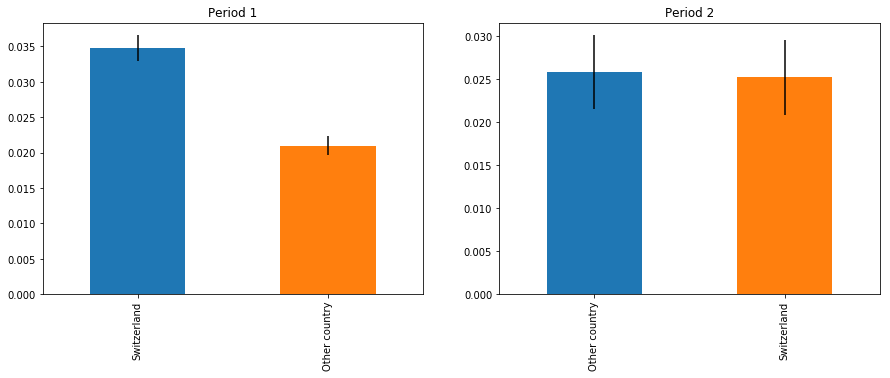

In [21]:
#Report information of NAN cases
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
print("There was not information for ",len(foodSwitzerlandBef["originsCat"])-sum(foodSwitzerlandBef["originsCat"]=="Switzerland")-sum(foodSwitzerlandBef["originsCat"]=="Other country")," products in the period 1.")
print("There was not information for ",len(foodSwitzerlandAft["originsCat"])-sum(foodSwitzerlandAft["originsCat"]=="Switzerland")-sum(foodSwitzerlandAft["originsCat"]=="Other country")," products in the period 2.")

#Plot origin of primary resources by periods
plt.subplot(1,2,1)
(foodSwitzerlandBef["originsCat"].value_counts()/len(foodSwitzerlandBef["originsCat"])).plot(kind='bar', yerr = [SBstd,OCBstd],title='Period 1')
plt.subplot(1,2,2)
(foodSwitzerlandAft["originsCat"].value_counts()/len(foodSwitzerlandAft["originsCat"])).plot(kind='bar', yerr = [SAstd,OCAstd],title='Period 2')

plt.show()

### 2.1.2 With respect to: Manufacture

First, bootstrapping for include confidence intervals to results

In [22]:
#before
propSB_100ite = np.zeros (100)
propOCB_100ite = np.zeros (100)

#after
propSA_100ite = np.zeros (100)
propOCA_100ite = np.zeros (100)

for iteration in range(0,100):
    #before
    temp_bef = foodSwitzerlandBef["manuCat"].sample(n=len(foodSwitzerlandBef), replace=True)
    propSB_100ite[iteration] = sum(temp_bef=="Switzerland")/len(foodSwitzerlandBef)
    propOCB_100ite[iteration] = sum(temp_bef=="Other country")/len(foodSwitzerlandBef)
    #after
    temp_aft = foodSwitzerlandAft["manuCat"].sample(n=len(foodSwitzerlandAft), replace=True)
    propSA_100ite[iteration] = sum(temp_aft=="Switzerland")/len(foodSwitzerlandAft)
    propOCA_100ite[iteration] = sum(temp_aft=="Other country")/len(foodSwitzerlandAft)
    

#Calculating standard deviation of count of each category
SBstd = propSB_100ite.std()
OCBstd = propOCB_100ite.std()
#Calculating standard deviation of count of each category
SAstd = propSA_100ite.std()
OCAstd = propOCA_100ite.std()

There was not information for  10871  products in the period 1.
There was not information for  1487  products in the period 2.


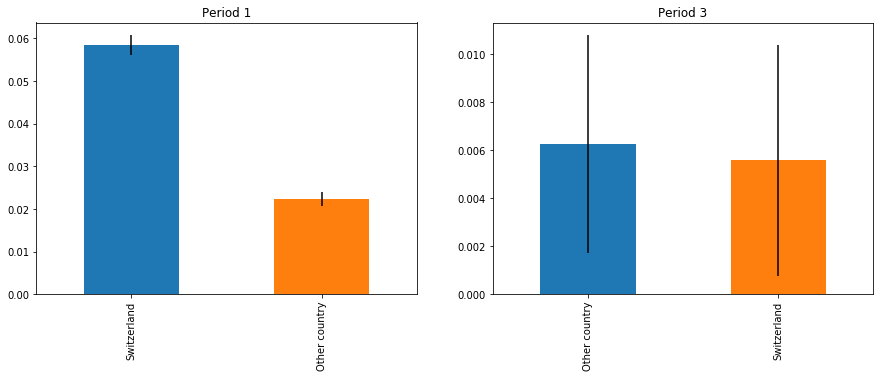

In [24]:
#Report information of NAN cases
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
print("There was not information for ",len(foodSwitzerlandBef["manuCat"])-sum(foodSwitzerlandBef["manuCat"]=="Switzerland")-sum(foodSwitzerlandBef["manuCat"]=="Other country")," products in the period 1.")
print("There was not information for ",len(foodSwitzerlandAft["manuCat"])-sum(foodSwitzerlandAft["manuCat"]=="Switzerland")-sum(foodSwitzerlandAft["manuCat"]=="Other country")," products in the period 2.")

#Plot origin of primary resources by periods
plt.subplot(1,2,1)
(foodSwitzerlandBef["manuCat"].value_counts()/len(foodSwitzerlandBef["manuCat"])).plot(kind='bar', yerr = [SBstd,OCBstd],title='Period 1')
plt.subplot(1,2,2)
(foodSwitzerlandAft["manuCat"].value_counts()/len(foodSwitzerlandBef["manuCat"])).plot(kind='bar', yerr = [SAstd,OCAstd],title='Period 3')

plt.show()

### 2.1.3 With respect to: Labels

In [25]:
#before
propSB_100ite = np.zeros (100)
propOCB_100ite = np.zeros (100)
#after
propSA_100ite = np.zeros (100)
propOCA_100ite = np.zeros (100)

for iteration in range(0,100):
    #before
    temp_bef = foodSwitzerlandBef["labCat"].sample(n=len(foodSwitzerlandBef), replace=True)
    propSB_100ite[iteration] = sum(temp_bef=="Related with Switzerland")/len(foodSwitzerlandBef)
    propOCB_100ite[iteration] = sum(temp_bef=="Other Label")/len(foodSwitzerlandBef)
    #after
    temp_aft = foodSwitzerlandAft["labCat"].sample(n=len(foodSwitzerlandAft), replace=True)
    propSA_100ite[iteration] = sum(temp_aft=="Related with Switzerland")/len(foodSwitzerlandAft)
    propOCA_100ite[iteration] = sum(temp_aft=="Other Label")/len(foodSwitzerlandAft)
    
    #Relation of time evolution and difference of products in each categories
    difpropB = propSB_100ite[iteration]-propOCB_100ite[iteration]
    difpropA = propSB_100ite[iteration]-propOCA_100ite[iteration]

#Calculating standard deviation of count of each category
SBstd = propSB_100ite.std()
OCBstd = propOCB_100ite.std()
#Calculating standard deviation of count of each category
SAstd = propSA_100ite.std()
OCAstd = propOCA_100ite.std()

There was not information for  11826  products in the period 1.
There was not information for  1627  products in the period 3.


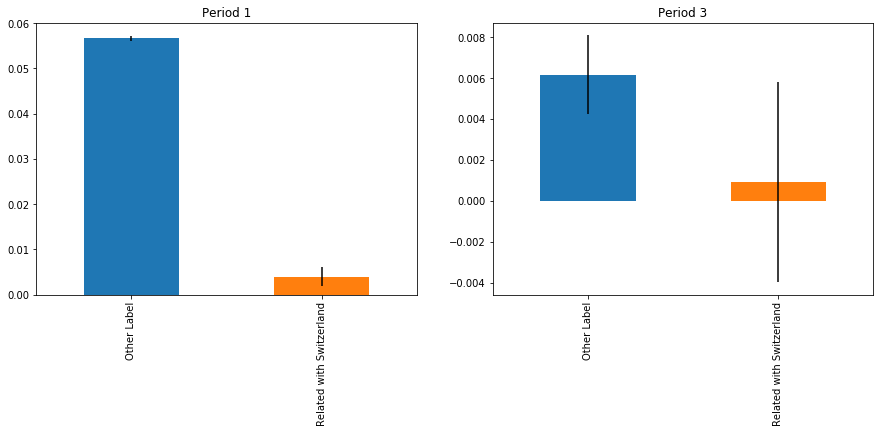

In [26]:
#Report information of NAN cases
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
print("There was not information for ",len(foodSwitzerlandBef["labCat"])-sum(foodSwitzerlandBef["labCat"]=="Switzerland")-sum(foodSwitzerlandBef["labCat"]=="Other country")," products in the period 1.")
print("There was not information for ",len(foodSwitzerlandAft["labCat"])-sum(foodSwitzerlandAft["labCat"]=="Switzerland")-sum(foodSwitzerlandAft["labCat"]=="Other country")," products in the period 3.")

#Plot origin of primary resources by periods
plt.subplot(1,2,1)
(foodSwitzerlandBef["labCat"].value_counts()/len(foodSwitzerlandBef["labCat"])).plot(kind='bar', yerr = [SBstd,OCBstd],title='Period 1')
plt.subplot(1,2,2)
(foodSwitzerlandAft["labCat"].value_counts()/len(foodSwitzerlandBef["labCat"])).plot(kind='bar', yerr = [SAstd,OCAstd],title='Period 3')

plt.show()